In [1]:
from fastai import *
from fastai.vision import *

%matplotlib inline

In [2]:
PATH = Path('../..').resolve()

sys.path.append(f'{PATH}/src')
from mxresnet import *
from ranger import Ranger

Mish activation loaded...
Mish activation loaded...


# Crossmatch $\alpha.40$A with other data

In [3]:
a40 = pd.read_csv(f'{PATH}/results/predictions/best_a40A-34.csv')
a40['d_fgas'] = a40.fgas_pred - a40.fgas_true


In [4]:
data = pd.read_csv(f'{PATH}/data/a40-SDSS_galaxy-properties.csv', index_col='AGCNr')
redshifts = pd.read_csv(f'{PATH}/data/a40.datafile3.csv', index_col='AGCNr', usecols=('AGCNr', 'z_sdss'))
density = pd.read_csv(f'{PATH}/data/a.40-delta_5.csv', index_col='AGCNr', usecols=('AGCNr', 'delta_5'))

In [5]:
df = a40.join(data, on='AGCNr', how='left').join(redshifts, on='AGCNr', how='left').join(density, on='AGCNr', how='left')
df.dropna(inplace=True)
df.sample(3)

,AGCNr,fgas_pred,fgas_true,d_fgas,Unnamed: 0,DR7ObjID,logMHI,logMstar,logSFR,Zgas,logfgas,logsSFR,z_sdss,delta_5
203,257892,0.530819,0.564564,-0.033745,10611.0,5.877420e+17,10.00,9.435436,-0.037650,8.687405,0.564564,-9.473086,0.05662,0.450386
1251,183073,0.656305,0.926987,-0.270682,1308.0,5.877346e+17,9.84,8.913013,-0.694051,8.586787,0.926987,-9.607063,0.03664,0.272709
1002,221130,-0.299473,-0.628314,0.328841,7307.0,5.877416e+17,9.29,9.918314,-0.162169,9.030924,-0.628314,-10.080483,0.02511,11.979127


In [6]:
df.shape

(983, 14)

# Plot altogether

In [7]:
display(np.corrcoef(df.logMstar, df.d_fgas)[0,1])
display(np.corrcoef(df.logSFR, df.d_fgas)[0,1])
display(np.corrcoef(df.Zgas, df.d_fgas)[0,1])
display(np.corrcoef(df[df.delta_5.notna()].delta_5, df[df.delta_5.notna()].d_fgas)[0,1])
display(np.corrcoef(df.fgas_true, df.d_fgas)[0,1])

0.12159563866134315

-0.06274374733178055

0.026890039961917186

0.015845155477075355

-0.44431511048485206

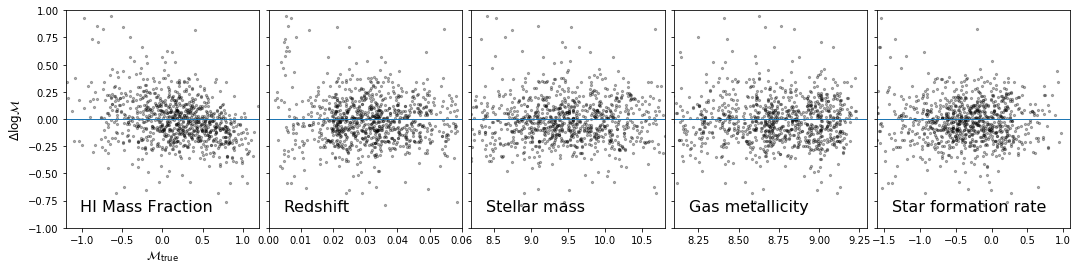

In [21]:
fig, [ax0, ax1, ax2, ax3, ax4] = plt.subplots(1, 5, figsize=(18, 4), sharey=True)

ax0.scatter(df.fgas_true, df.d_fgas, c='k', s=5, alpha=0.3)
ax0.text(0.075, 0.075, r'HI mass fraction', fontsize=16, transform=ax0.transAxes)
ax0.set_xlim(-1.2, 1.2)
ax0.set_ylim(-1, 1)
ax0.set_xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=12)
ax0.set_ylabel(r'$\Delta \log \mathcal{M}$', fontsize=12)


ax1.scatter(df.z_sdss, df.d_fgas, c='k', s=5, alpha=0.3)
ax1.text(0.075, 0.075, r'Redshift', fontsize=16, transform=ax1.transAxes)
ax1.set_xlim(0, 0.06)
ax1.set_ylim(-1, 1)
ax1.set_xlabel(r'$z$', fontsize=12)



ax2.scatter(df.logMstar, df.d_fgas, c='k', s=5, alpha=0.3)
ax2.text(0.075, 0.075, r'Stellar mass', fontsize=16, transform=ax2.transAxes)
ax2.set_xlim(8.2, 10.8)
ax2.set_ylim(-1, 1)
ax2.set_xlabel(r'$\log(M_★/M_\odot)$', fontsize=12)

ax3.scatter(df.Zgas, df.d_fgas, c='k', s=5, alpha=0.3)
ax3.text(0.075, 0.075, r'Gas metallicity', fontsize=16, transform=ax3.transAxes)
ax3.set_xlim(8.1, 9.3)
ax3.set_ylim(-1, 1)
ax3.set_xlabel(r'12 + log(O/H)', fontsize=12)

ax4.scatter(df.logSFR, df.d_fgas, c='k', s=5, alpha=0.3)
ax4.text(0.075, 0.075, r'Star formation rate', fontsize=16, transform=ax4.transAxes)
ax4.set_xlim(-1.6, 1.1)
ax4.set_ylim(-1, 1)
ax3.set_xlabel(r'log(SFR/$M_\odot~{\rm yr}^{-1})$', fontsize=12)

for ax in [ax0, ax1, ax2, ax3, ax4]:
    ax.axhline(0, lw=1)

fig.subplots_adjust(wspace=0.05)

fig.savefig(f'{PATH}/results/figures-updated/residual-trends_a40A.pdf')

# Use combined predictions

In [9]:
combined = pd.read_csv(f'{PATH}/results/predictions/best_combined-100.csv')
combined['d_fgas'] = combined.fgas_pred - combined.fgas_true

In [10]:
(combined.d_fgas**2).mean()**0.5

0.27443570675103285

In [11]:
# xgass -> AGCNr crossmatch
# note that those without a match go to 0
xg = pd.read_csv(f'{PATH}/data/xGASS_representative_sample.csv')
xg_lookup = {k:v for k,v in zip(xg.GASS, xg.AGCnr)}



In [12]:
def to_AGCNr(s) -> int:
    """converts ID string to AGC number (int)"""
    if s.startswith('AGC'):    return int(s[4:])
    elif s.startswith('GASS'): return xg_lookup[int(s[5:])]


In [13]:
# rename IDs
combined['AGCNr'] = combined.id.apply(lambda x: to_AGCNr(x))

In [14]:
# remove non-matches
combined = combined[combined.AGCNr != 0].copy()
combined.shape

(1625, 5)

In [15]:
df = (
    combined
        .join(data, on='AGCNr', how='left')
        .join(redshifts, on='AGCNr', how='left')
        .join(density, on='AGCNr', how='left')
)

df.dropna(inplace=True)

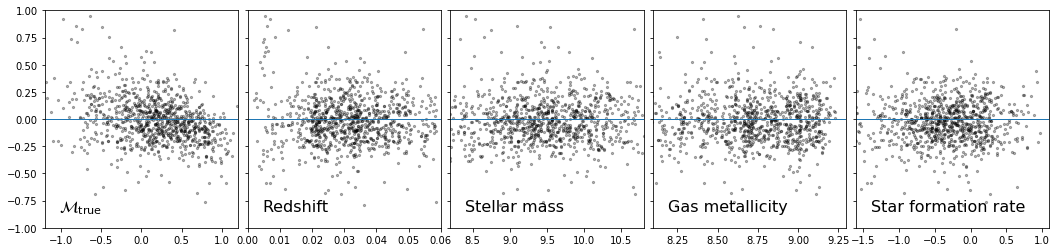

In [16]:
fig, [ax0, ax1, ax2, ax3, ax4] = plt.subplots(1, 5, figsize=(18, 4), sharey=True)

ax0.scatter(df.fgas_true, df.d_fgas, c='k', s=5, alpha=0.3)
ax0.text(0.075, 0.075, r'$\mathcal{M}_{\rm true}$', fontsize=16, transform=ax0.transAxes)
ax0.set_xlim(-1.2, 1.2)
ax0.set_ylim(-1, 1)


ax1.scatter(df.z_sdss, df.d_fgas, c='k', s=5, alpha=0.3)
ax1.text(0.075, 0.075, r'Redshift', fontsize=16, transform=ax1.transAxes)
ax1.set_xlim(0, 0.06)
ax1.set_ylim(-1, 1)



ax2.scatter(df.logMstar, df.d_fgas, c='k', s=5, alpha=0.3)
ax2.text(0.075, 0.075, r'Stellar mass', fontsize=16, transform=ax2.transAxes)
ax2.set_xlim(8.2, 10.8)
ax2.set_ylim(-1, 1)

ax3.scatter(df.Zgas, df.d_fgas, c='k', s=5, alpha=0.3)
ax3.text(0.075, 0.075, r'Gas metallicity', fontsize=16, transform=ax3.transAxes)
ax3.set_xlim(8.1, 9.3)
ax3.set_ylim(-1, 1)

ax4.scatter(df.logSFR, df.d_fgas, c='k', s=5, alpha=0.3)
ax4.text(0.075, 0.075, r'Star formation rate', fontsize=16, transform=ax4.transAxes)
ax4.set_xlim(-1.6, 1.1)
ax4.set_ylim(-1, 1)

for ax in [ax0, ax1, ax2, ax3, ax4]:
    ax.axhline(0, lw=1)

fig.subplots_adjust(wspace=0.05)

fig.savefig(f'{PATH}/results/figures-updated/residual-trends_combined.pdf')